In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

In [2]:
df = pd.read_excel('/Users/robertdefilippi/Google Drive/Programming/data-science-ipython-notebooks/Data/cohort_xlsx.xlsx')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [33]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


In [4]:
# This shifts the index from OrderId to UserId
df.set_index('UserId', inplace=True)

In [5]:
# New column
# groupby() --> Group series using mapper 
df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))

# Set the new index to "0" and do not make a new object.
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


In [6]:
# Find this group first
# Only values of ChortGroup and OrderPeriod
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# grouped.describe()

In [7]:
# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

In [8]:
# make the column names more meaningful
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalOrders  TotalUsers  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01               30          22       1850.26
            2009-02               25           8       1351.07
            2009-03               26          10       1357.36
            2009-04               28           9       1604.50
            2009-05               26          10       1575.63

We want to see how each cohort has behaved in the months follow their first pruchase. So we need to index each cohort to their first purchase month.

To so this we need to create a function.

In [9]:
def cohort_period(df):
    """
    Creates a CohortPeriod column, which is the Nth period based on the user's
    first purchase.
    
    Example:
    ------
    Say you want to get the 3rd month for every user:
        
        df.sort(['UserId', 'OrderTime'], inplace = True])
        
        df = df.groupby('UserId').apply(cohort_period)
        
        df[df.CohortPeriod == 3]
            
    """
    
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level = 0).apply(cohort_period)
cohorts.head()

TotalOrders  TotalUsers  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01               30          22       1850.26             1
            2009-02               25           8       1351.07             2
            2009-03               26          10       1357.36             3
            2009-04               28           9       1604.50             4
            2009-05               26          10       1575.63             5

Ok, lets take some time to test if the DataFrames are correct.

In [10]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
# Remember ix is for rows
y = cohorts.ix[('2009-01', '2009-01')]

In [22]:
x['TotalCharges'] = type(x['TotalCharges'])

TypeError: unbound method repeat() must be called with Series instance as first argument (got int instance instead)

In [23]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

In [25]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

In [26]:
cohorts['TotalUsers'].unstack(0).head()


CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22,15,13,39,50,32,50,31,37,54,130,65,95,100,24
2,8,3,4,13,13,15,23,11,15,17,32,17,50,19,NaN
3,10,5,5,10,12,9,13,9,14,12,26,18,26,NaN,NaN
4,9,1,4,13,5,6,10,7,8,13,29,7,NaN,NaN,NaN
5,10,4,1,6,4,7,11,6,13,13,13,NaN,NaN,NaN,NaN


In [27]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


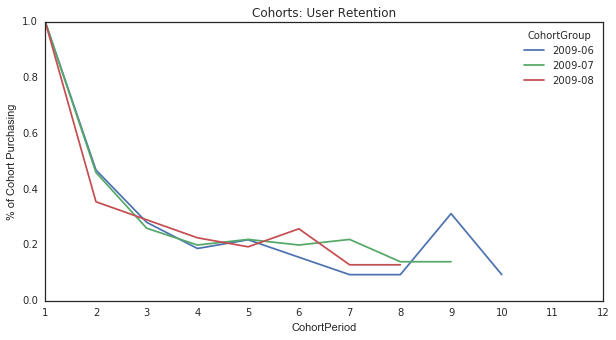

In [31]:
import seaborn as sns
sns.set(style='white')

user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
sns.plt.title('Cohorts: User Retention')
sns.plt.xticks(np.arange(1, 12.1, 1))
sns.plt.xlim(1, 12)
sns.plt.ylabel('% of Cohort Purchasing');

/Users/robertdefilippi/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


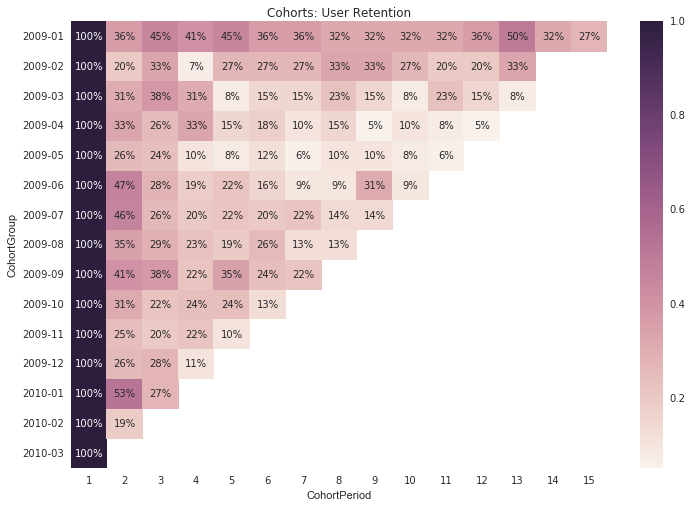

In [29]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/

import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');